# Demo Notebook

Only the necessary code for the presentation.

In [1]:
%matplotlib inline
# Imports
from src import model, thymio, vision, pathfinder, navglobal, navlocal, filtering, draw
import numpy as np
import time

In [2]:
# Use the webcam, adapt the index according to your computer and the webcamp port
# This index corresponds to OpenCV's VideoCapture index
source = vision.WebcamSource(index=2, recording='filter.avi')
# Create our vision tools
tools = vision.VisionTools()

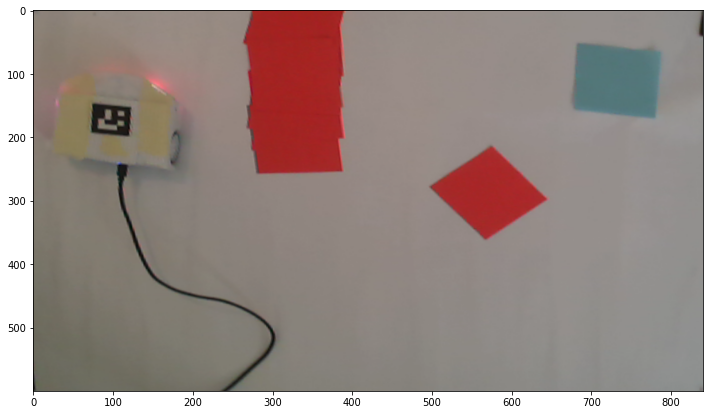

In [3]:
# Calibrate with the aruco markers, this can take a few frames
ready = False
while not ready:
    img = source.get_frame()
    corners_by_id = tools.get_aruco_dict(img)
    try:
        calibrated = tools.get_aruco_calibrated(img, corners_by_id)
        ready = True
    except:
        ready = False
draw.plot_image(calibrated)

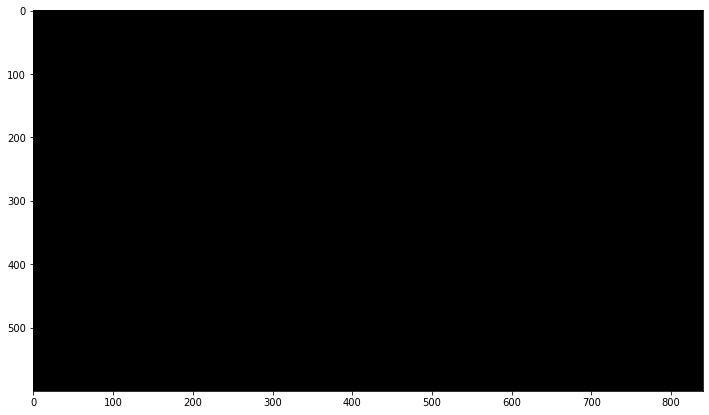

In [4]:
# Pick the right blue bounds
blue_bounds=vision.HSVBound(lb=np.array([90, 100, 0]), ub=np.array([120, 255, 255]))
mask = tools.get_color_mask(calibrated, blue_bounds)
draw.plot_image(mask)

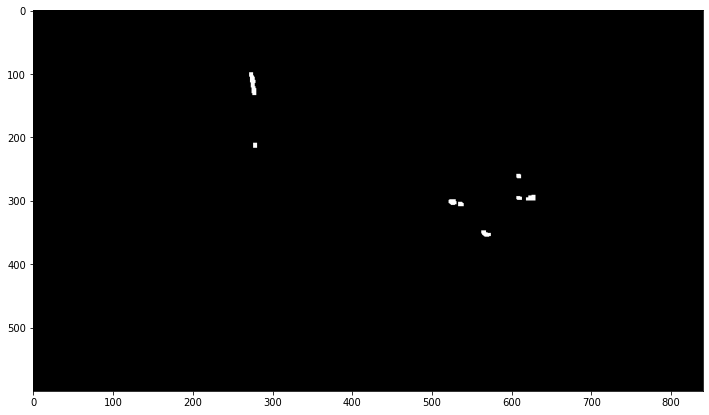

In [5]:
# Pick the right red bounds
red_bounds=vision.HSVBound(lb=np.array([160, 150, 0]), ub=np.array([180, 255, 255]))
mask = tools.get_color_mask(calibrated, red_bounds)
draw.plot_image(mask)

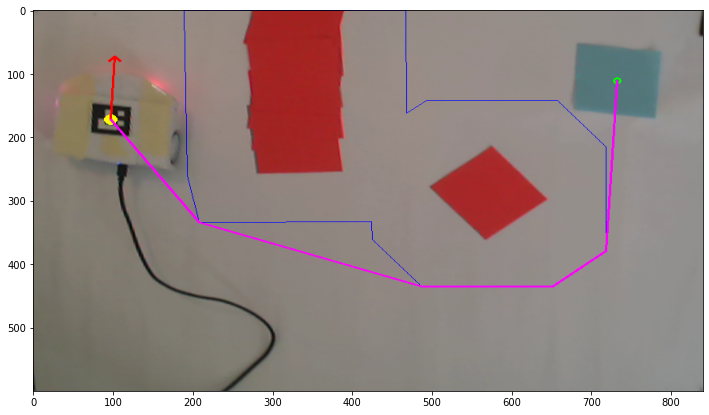

In [6]:
# Our vision pipeline is ready to be used!
viz = vision.VisionPipeline(source, tools=tools, red_bounds=red_bounds, blue_bounds=blue_bounds, dilate_factor=160)
# Give it to the camera thread to calibrate recording
source.camera_thread.pipeline = viz
# Compute the world
world = viz.analyze_scene()
# Compute the path
path = pathfinder.find_path(world, tools.target_resolution)
# Give info to camera thread for recording
source.camera_thread.world = world
source.camera_thread.path = path
# Display result
result = draw.draw_world(calibrated, world)
result = draw.draw_path(result, path)
draw.plot_image(result)

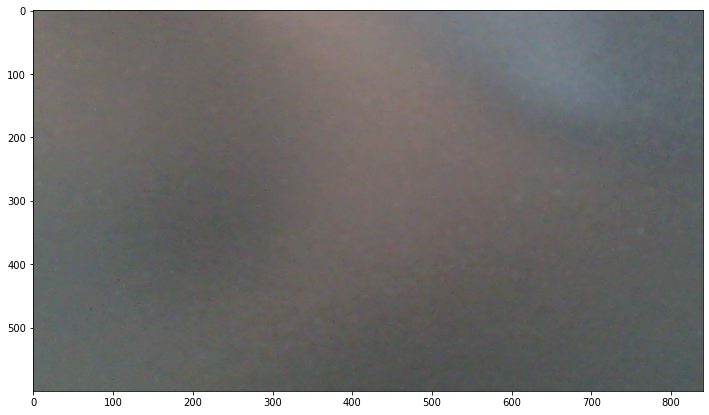

In [7]:
# Connect with the Thymio
th = thymio.Thymio()
# Setup global and local navigation object
navigator = navglobal.GlobalNavigation(path)
avoider = navlocal.LocalNavigation()
# Flag to check if we were in local avoidance
# This is used to recompute the path and update global navigation
was_in_avoidance = False
# Create the filter with initial state
kalman = filtering.Filter(world.robot)

# Setup recording
source.camera_thread.setup_recording()

# While we have not reached the goal
while not world.robot_at_goal(60):
    # Read data from the sensors
    sensor_data = th.read_sensor_data()

    # Check whether to use local or global navigation
    if avoider.avoidance_mode(sensor_data):
        command = avoider.next_command(sensor_data)
        was_in_avoidance = True
    else:
        # Recompute path if we left local avoidance
        if was_in_avoidance:
            path = pathfinder.find_path(world, tools.target_resolution)
            navigator = navglobal.GlobalNavigation(path)
            was_in_avoidance = False
            # Give it to recording
            source.camera_thread.path = path
        command = navigator.next_command(world.robot)
    # Send the command to the Thymio
    th.process_command(command)
    # Read the pose from the camera
    pose = viz.get_robot_pose()
    # if pose is not None:
    #     world.robot = pose
    # Update state with the filter
    world.robot = kalman.update_robot(viz.last_robot_pose, command, sensor_data, camera=pose is not None)
# Disconnect the Thymio
th.stop()

# Show the last frame
draw.plot_image(viz.latest_frame)
# Stop recording
time.sleep(2)
source.camera_thread.out = None

In [ ]:
source.camera_thread.out = None
th.stop()